In [1]:
import lxml.html as parser
import requests
import csv
import re
from urllib.parse import urlsplit, urljoin
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [159]:
def get_float(string_):
    return float(''.join(re.findall('\d+',string_)))
def get_cep(string_):
    return ''.join(re.findall('\d{5}-\d{3}',string_))
def sub_string(string_):
    return string_.strip()
def get_links_page(start_url):
    r = requests.get(start_url)
    html = parser.fromstring(r.text)
    links = html.xpath("//a[@class='OLXad-list-link']/@href")
    links = [urljoin(start_url, l) for l in links]
    links = [urlsplit(l)._replace(query="").geturl() for l in links]
    next_page = html.xpath("//div[@class='module_pagination']//ul[@class='list']//li[@class='item next']//a[@class='link'][@rel='next']/@href")[0]
    return links, next_page
def get_atributes(links):
    tp_imovel = []
    condominio = []
    iptu = []
    area = []
    quartos = []
    banheiros = []
    garagem = []
    prices = []
    cep = []
    bairro = []
    city = []
    url = links
    for i in links:
        time.sleep(random.randint(1,3))
        r = requests.get(i)
        product_html = parser.fromstring(r.text)        
        des_dict = dict(zip(
            product_html.xpath("//ul[@class='list square-gray']/li[@class='item']/p[@class='text']/span[@class='term']/text()"),
            product_html.xpath("//ul[@class='list square-gray']/li[@class='item']/p[@class='text']/strong[@class='description']/text()")))

        try:
            tp_imovel.append(sub_string(des_dict['Tipo:']))
        except:
            tp_imovel.append('')
        try:
            condominio.append(get_float(des_dict['Condomínio:']))
        except:
            condominio.append(None)
        try:
            iptu.append(get_float(des_dict['IPTU:']))
        except:
            iptu.append(None)
        try:
            area.append(get_float(des_dict['Área útil:']))
        except:
            area.append(None)
        try:
            quartos.append(get_float(des_dict['Número de quartos:']))
        except:
            quartos.append(None)
        try:
            banheiros.append(get_float(des_dict['Número de banheiros:']))
        except:
            banheiros.append(None)
        try:
            garagem.append(get_float(des_dict['Vagas na garagem:']))
        except:
            garagem.append(None)
        try:
            city.append(sub_string(des_dict['Município:']))
        except:
            city.append('')
        try:
            cep.append(get_cep(des_dict['CEP do imóvel:']))
        except:
            cep.append('')
        try:
            bairro.append(sub_string(des_dict['Bairro:']))
        except:
            bairro.append('')
        try:
            prices.append(get_float(product_html.xpath("//h3[@class='price']/span[@class='actual-price']/text()")[0]))
        except:
            prices.append(None)
    df = pd.DataFrame({'tp_imovel':tp_imovel,'price':prices,'cond':condominio,
                       'iptu':iptu,'area':area,'quartos':quartos,'banheiros':banheiros,
                       'garagem':garagem,'cep':cep,'City':city,'Bairro':bairro,'url':links})        
    return df

In [167]:
df_t = pd.DataFrame()
next_page = 'https://sp.olx.com.br/grande-campinas/regiao-de-campinas/campinas/imoveis/aluguel/2-quartos?gsp=1'
for i in range(200):
    print('Página =>',i)
    try:
        n_links, next_page = get_links_page(next_page)
        print('get %d values'%(len(n_links)))
        df = get_atributes(n_links)
        df_t = pd.concat([df_t,df])
    except:
        print('Erro na busca de novas páginas.')
        break
df_t.to_excel('Anúncios_29_01_2019_agora_vai.xlsx')

Página => 0
get 50 values
Página => 1
get 50 values
Página => 2
get 50 values
Página => 3
get 50 values
Página => 4
get 50 values
Página => 5
get 50 values
Página => 6
get 50 values
Página => 7
get 50 values
Página => 8
get 50 values
Página => 9
get 50 values
Página => 10
get 50 values
Página => 11
get 50 values
Página => 12
get 50 values
Página => 13
get 50 values
Página => 14
get 50 values
Página => 15
get 50 values
Página => 16
get 50 values
Página => 17
get 50 values
Página => 18
get 50 values
Página => 19
get 50 values
Página => 20
get 50 values
Página => 21
get 50 values
Página => 22
get 50 values
Página => 23
get 50 values
Página => 24
get 50 values
Página => 25
get 50 values
Página => 26
get 50 values
Página => 27
get 50 values
Página => 28
get 50 values
Página => 29
get 50 values
Página => 30
Erro na busca de novas páginas.


In [2]:
df = pd.read_excel("Anúncios_29_01_2019_agora_vai.xlsx")
df = df[(~df.price.isnull()) & (~df.cond.isnull()) & (~df.area.isnull())]
df['garagem'] = df.garagem.fillna(0)

In [13]:
X = df['price'].values.reshape(-1,1)

In [14]:
from sklearn.cluster import KMeans

In [15]:
kmean = KMeans(random_state=22,n_clusters=2)

In [16]:
kmean.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=22, tol=0.0001, verbose=0)

In [17]:
df['kmean_label'] = kmean.predict(X)

In [18]:
df = df[df.kmean_label==0]
df['Al_Con'] = df.price+df.cond

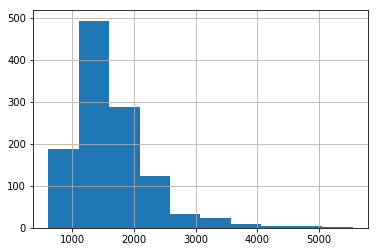

In [19]:
df.Al_Con.hist()

/home/samuel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


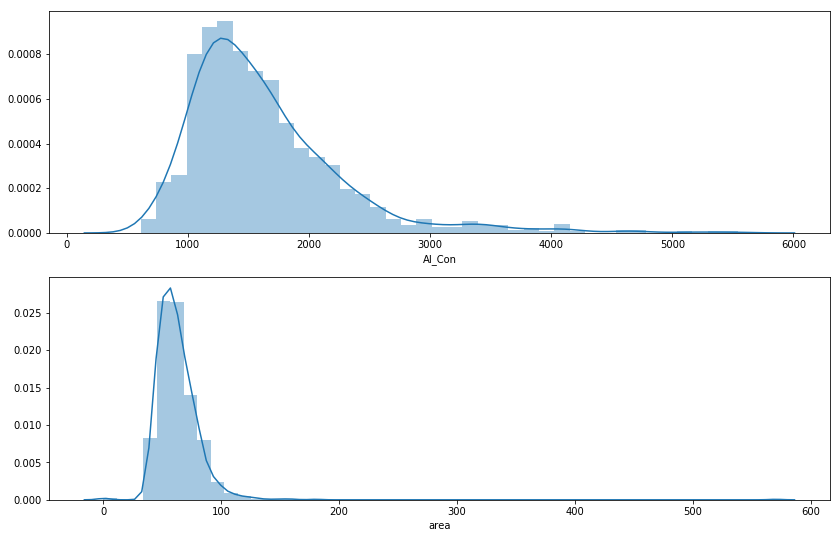

In [20]:
import seaborn as sns
plt.figure(figsize=(14,9))
ax = plt.subplot(211)
sns.distplot(df.Al_Con,ax=ax)
ax2 = plt.subplot(212)
sns.distplot(df.area,ax=ax2)

In [21]:
df_plot = df[(df.Al_Con<1500) & (df.area<70) & (df.area>40)]
bairros = list(df_plot.groupby('Bairro').size().sort_values(ascending=False)[:20].index)
df_plot = df_plot[df_plot.Bairro.isin(bairros)]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

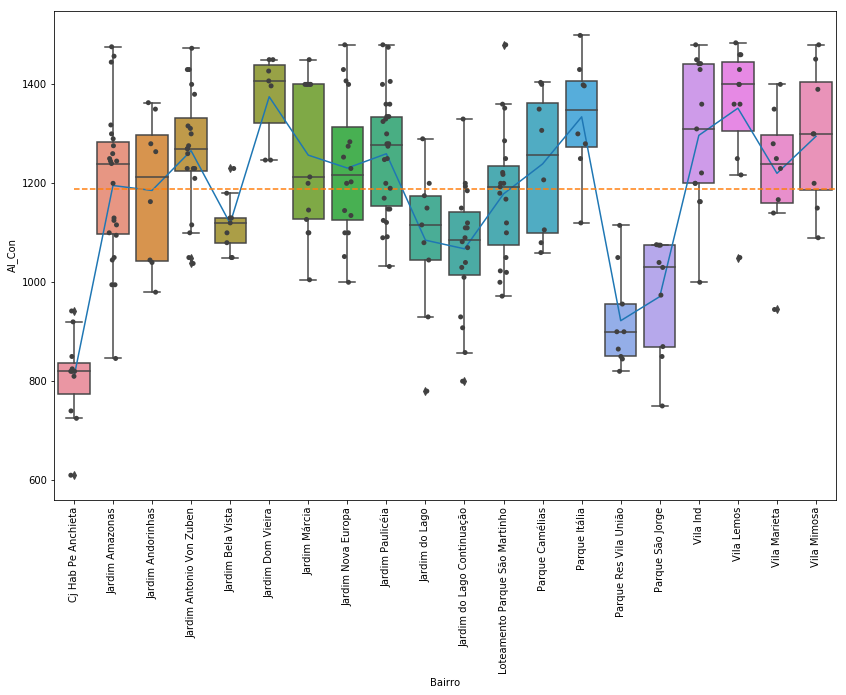

In [42]:
plt.figure(figsize=(14,9))
ax = plt.subplot(111)
sns.boxplot(data=df_plot.sort_values('Bairro'), x='Bairro',y='Al_Con',ax = ax)
df_plot.groupby('Bairro')['Al_Con'].mean().sort_index().plot(kind='line',ax=ax)
ax = sns.stripplot(x="Bairro", y="Al_Con", data=df_plot.sort_values(by='Bairro'), color=".25",jitter=True)
ax.plot([0,len(df_plot.Bairro.unique())],[df_plot.Al_Con.mean(),df_plot.Al_Con.mean()],'--')
plt.xticks(rotation=90)

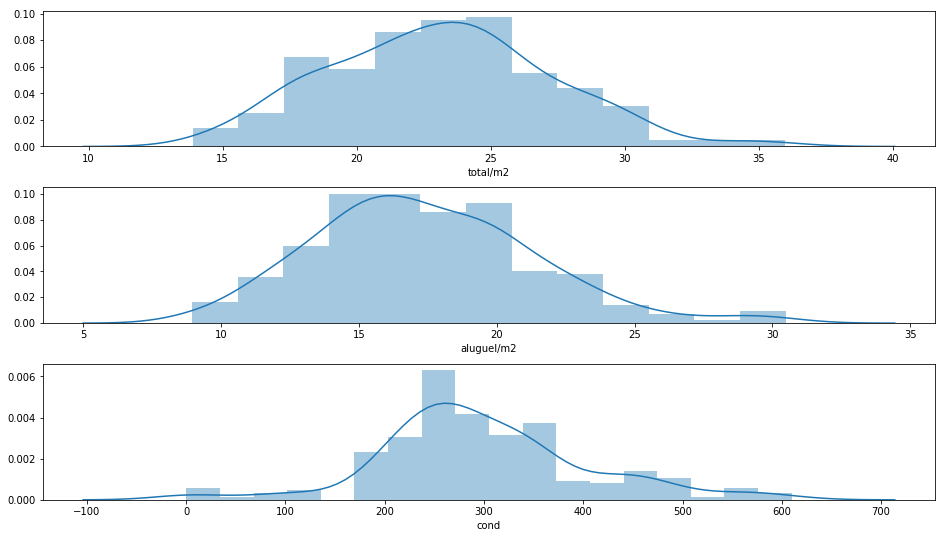

In [70]:
df_plot['total/m2'] = (df_plot.Al_Con/df_plot.area)
df_plot['aluguel/m2'] = (df_plot.price/df_plot.area)
fig = plt.figure(figsize=(16,9))
fig.subplots_adjust(hspace=0.3)
ax = plt.subplot(311)
sns.distplot(df_plot['total/m2'],ax=ax)
ax2 = plt.subplot(312)
sns.distplot(df_plot['aluguel/m2'],ax=ax2)
ax3 = plt.subplot(313)
sns.distplot(df_plot.cond,ax=ax3)